In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hazm
import re
from urlextract import URLExtract
import emojis
import tqdm
from tqdm import tqdm
from hazm import *
import nltk
from wordcloud import WordCloud
from wordcloud_fa import WordCloudFa
import arabic_reshaper
from arabic_reshaper import reshape
from bidi.algorithm import get_display

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df=pd.read_csv(r'train.csv')

In [3]:
df.head(7)

,Unnamed: 0,TEXT[1]/text(),CAT[2]/text()
0,44574,\nاز سوي كميسيون ماده 10 \nاحزابكارگزاران سازن...,Politics
1,79972,\nخصوصي سازي كارخانه هاي چاي سال آينده \nآغاز ...,Economy
2,134945,\nتوضيح يك مطلب \nسوم بهمن ماه امسال گزارش طرح...,Science and Culture
3,59035,\nبهاي گازوئيل و بنزين در \nفرانسه افزايش يافت...,Economy
4,151154,\nرئيس سازمان حج و زيارت اعلام كرد \n شهريور 1...,Science and Culture
5,137866,\nهمزمان با روز جهاني موزه و هفته ميراث \nجديد...,Science and Culture
6,149471,\nنگراني درلوشامپيونا \nسهيلا قاسمي \nبازار نق...,Sport


In [4]:
df.shape

(59993, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59993 entries, 0 to 59992
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      59993 non-null  int64 
 1   TEXT[1]/text()  59993 non-null  object
 2   CAT[2]/text()   59993 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
df['TEXT[1]/text()'][0]

'\nاز سوي كميسيون ماده 10 \nاحزابكارگزاران سازندگي مجوز \nفعاليت گرفت \nتقاضاي تاسيس حزبكارگزاران سازندگي ايران مورد پذيرش و \nموافقت كميسيون ماده 10 احزاب وزارت كشور قرار گرفت. \nبه گزارش روابط عمومي وزارت كشور، سه حزب ديگر نيز به \nنام هاي حزب سعادت انجمن ايران، زرتشتيان اروميه و \nانجمن فارغ التحصيلان ژاپن درخواست فعاليت رسمي نمودند كه \nپس از تحقيق و بررسي هاي لازم در ابتداي امر، با اعطاي مجوز \nتاسيس احزاب مذكور موافقت شد. \nپروانه فعاليت اين گروهها نيز پس از طي روال قانوني اعطاء \nخواهد شد. \n'

In [7]:
df['TEXT[1]/text()'][1]

'\nخصوصي سازي كارخانه هاي چاي سال آينده \nآغاز مي شود \nمديرعامل سازمان چاي كشور اعلام كرد: براساس مصوبه هيات \nوزيران كه به تصويب شوراي اقتصاد نيز رسيده است، طرح \nساماندهي ساختار چاي كشور درقالبآزادسازي كارخانجات چاي \nكشور از سال 79 به اجرا درمي آيد. \nدكتر محمدعلي نجفي ديروز گفت: اين طرح كه در طول برنامه \nپنجساله سوم توسعه به تدريج اجرا مي شود، خصوصي سازي و \nشكوفايي چاي كشور را در آينده اي نه چندان دور درپيش \nدارد. وي افزود: به موجب اين مصوبه ازسال 79 هرساله 20 \nدرصد از كارخانجات چاي كشور ضمن آزادسازي، راسا اقدام به \nخريد برگ سبز چاي براساس قيمت تضميني كرده و دربازار چاي \nشركت خواهند كرد. \nنجفي متذكر شد: بااجراي طرح آزادسازي، حمايت هاي دولت \nنيز دركناركارخانه هاي چاي سازي كشور كماكان ادامه \nمي يابد. \nمديرعامل سازمان چاي كشور تصريح كرد: براساس بند ديگراين \n مصوبه، براي حمايت از اقشار آسيبپذير جامعه، سازمان چاي، \nهرساله بخشي ازتوليدات كارخانه هاي چاي سازي كشور را \nخريداري و با قيمت يارانه اي توزيع مي كند. به گفته نجفي، \nمقدار و قيمت چاي توزيعي يارانه اي، با پيشنهاد مشتر

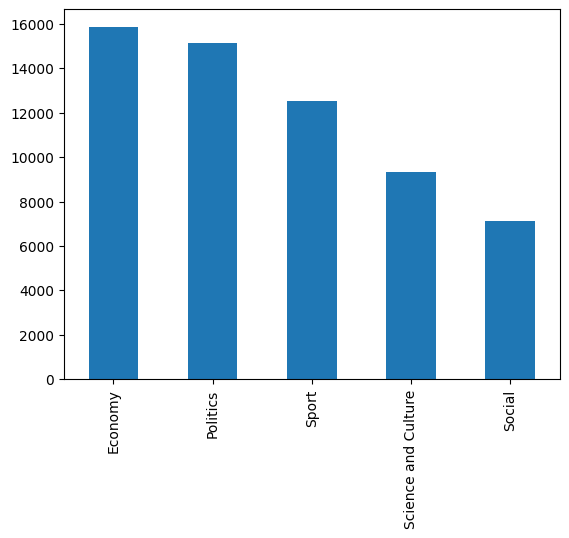

In [8]:
df['CAT[2]/text()'].value_counts().plot(kind='bar')
plt.show()

In [9]:
df=df.rename(columns={"TEXT[1]/text()": "text", "CAT[2]/text()": "class"})

In [10]:
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

def convert_fa_numbers(input_str):
    mapping = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
        '.': '.',
    }
    return _multiple_replace(mapping, input_str)


def convert_ar_characters(input_str):
    """
    Converts Arabic chars to related Persian unicode char
    :param input_str: String contains Arabic chars
    :return: New str with converted arabic chars
    """
    mapping = {
        'ك': 'ک',
        'ى': 'ی',
        'ي': 'ی',
        'ئ':'ی',
        'إ':'ا',
        'أ':'ا',
        'ة':'ه',
        'ؤ':'و'
    }
    return _multiple_replace(mapping, input_str)


def preprocess(text):
    extractor = URLExtract()
    for url in extractor.gen_urls(text):
        text = text.replace(url,'<URL>')
    emj = emojis.get(text)
    for i in emj:
        if i in text:
            text = text.replace(i,'<emoji>')
    text = convert_fa_numbers(text)
    text = convert_ar_characters(text)
    # regex to detect and replace all smilies in the text with <smiley>
    text = re.sub(r"(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|8-\)|:\s?\||;\s?\)|:-\*|:-\||:-\(|:\s?P|:-P|:-p|:-b|:-O|:-o|:-0|:-\@|:\$|:-\^|:-&|:-\*|:-\+|:-\~|:-\`|:-\>|:-\<|:-\}|:-\{|\[:\s?\]|\[:\s?\]|:\s?\]|:\s?\[|:\s?\}|:\s?\{)",'<smiley>',text)
    text = text.lower() # we lowercase here to prevent changes in the URLs and smilies
    text = text.strip()
    text = re.sub(r'[<>#.:()"\'!?؟،,@$%^&*_+\[\]/]', ' ', text)
    text = re.sub(r'[\s]{2,}', ' ', text)
    text = re.sub(r'(\w)\1{2,}', r'\1',text)
    if re.search(r'[\u0600-\u06FF]', text):
        return(text)
    else:
        return 'None'

In [11]:
tqdm.pandas()

df['PP_text'] = df['text'].progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████████| 59993/59993 [37:18<00:00, 26.80it/s]


In [16]:
df.isna().sum()

Unnamed: 0    0
text          0
class         0
PP_text       0
dtype: int64

In [18]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [20]:


# def normalize_text(text):
#     return normalizer.normalize(text)
# def remove_stopwords(text):
#     tokens = word_tokenize(normalizer.normalize(text))
#     filtered_tokens = [token for token in tokens if token not in stopwords_list()]
#     return ' '.join(filtered_tokens)
# df['PP_Text_0'] = df['PP_text'].apply(normalize_text)


In [30]:
normalizer = Normalizer()
lemma=Lemmatizer()

def preprocess_2(text):
    normalized_text = normalizer.normalize(text)
    tokens = word_tokenize(normalized_text)
    lemmas = [lemma.lemmatize(token) for token in tokens]
    filtered_lemmas = [lemma for lemma in lemmas if lemma not in stopwords_list()]
    return ' '.join(filtered_lemmas)


In [34]:
df['PP_Text_1'] = df['text'].progress_apply(preprocess_2)

100%|██████████████████████████████████████████████████████████████████████████| 59993/59993 [3:42:25<00:00,  4.50it/s]


In [37]:
df['PP_Text_1'][0]

'سو کمیسیون ماده ۱۰ احزابکارگزاران سازندگی مجوز فعالیت گرفت#گیر تقاضای تاسیس حزبکارگزاران سازندگی ایران پذیرش موافقت کمیسیون ماده ۱۰ احزاب وزارت کشور قرار گرفت#گیر . گزارش روابط عموم وزارت کشور ، حزب نام حزب سعادت انجمن ایران ، زرتشت ارومیه انجمن فارغ التحصیلان ژاپن درخواست فعالیت رسم نمود#نما تحقیق بررسی ، اعطا مجوز تاسیس احزاب مذکور موافقت شد#شو . پروانه فعالیت گروه روال قانون اعطاء شد#شو .'

In [39]:
WT=word_tokenize(df['PP_Text_1'][0])

In [40]:
WT

['سو',
 'کمیسیون',
 'ماده',
 '۱۰',
 'احزابکارگزاران',
 'سازندگی',
 'مجوز',
 'فعالیت',
 'گرفت#گیر',
 'تقاضای',
 'تاسیس',
 'حزبکارگزاران',
 'سازندگی',
 'ایران',
 'پذیرش',
 'موافقت',
 'کمیسیون',
 'ماده',
 '۱۰',
 'احزاب',
 'وزارت',
 'کشور',
 'قرار',
 'گرفت#گیر',
 '.',
 'گزارش',
 'روابط',
 'عموم',
 'وزارت',
 'کشور',
 '،',
 'حزب',
 'نام',
 'حزب',
 'سعادت',
 'انجمن',
 'ایران',
 '،',
 'زرتشت',
 'ارومیه',
 'انجمن',
 'فارغ',
 'التحصیلان',
 'ژاپن',
 'درخواست',
 'فعالیت',
 'رسم',
 'نمود#نما',
 'تحقیق',
 'بررسی',
 '،',
 'اعطا',
 'مجوز',
 'تاسیس',
 'احزاب',
 'مذکور',
 'موافقت',
 'شد#شو',
 '.',
 'پروانه',
 'فعالیت',
 'گروه',
 'روال',
 'قانون',
 'اعطاء',
 'شد#شو',
 '.']

In [43]:
def remove_hashtags(text):
    tokens = word_tokenize(text)
    processed_tokens = []
    for token in tokens:
        if '#' in token:
            token = token.split('#')[-1]
        processed_tokens.append(token)
    processed_text = ' '.join(processed_tokens)
    
    return processed_text


df['PP_Text_2'] = df['PP_Text_1'].progress_apply(remove_hashtags)

100%|██████████████████████████████████████████████████████████████████████████| 59993/59993 [00:14<00:00, 4198.33it/s]


In [44]:
WT2=word_tokenize(df['PP_Text_2'][0])

In [68]:
print(WT2)

['سو', 'کمیسیون', 'ماده', '۱۰', 'احزابکارگزاران', 'سازندگی', 'مجوز', 'فعالیت', 'گیر', 'تقاضای', 'تاسیس', 'حزبکارگزاران', 'سازندگی', 'ایران', 'پذیرش', 'موافقت', 'کمیسیون', 'ماده', '۱۰', 'احزاب', 'وزارت', 'کشور', 'قرار', 'گیر', '.', 'گزارش', 'روابط', 'عموم', 'وزارت', 'کشور', '،', 'حزب', 'نام', 'حزب', 'سعادت', 'انجمن', 'ایران', '،', 'زرتشت', 'ارومیه', 'انجمن', 'فارغ', 'التحصیلان', 'ژاپن', 'درخواست', 'فعالیت', 'رسم', 'نما', 'تحقیق', 'بررسی', '،', 'اعطا', 'مجوز', 'تاسیس', 'احزاب', 'مذکور', 'موافقت', 'شو', '.', 'پروانه', 'فعالیت', 'گروه', 'روال', 'قانون', 'اعطاء', 'شو', '.']


In [47]:
df['PP_Text_2'][200]

'شورا نگهبان صلاحیت حجت الاسلام والمسلمین محمد هاشم تایید کن نامزد تایید صلاحیت انتخابات خبرگان ۱۶۰ تن شورا نگهبان ، صلاحیت حجت الاسلام والمسلمین محمد هاشم امام جمعه رفسنجان نامزد مجلس خبرگان رهبر تاییدکرد . نهایی شورا نگهبان هاشم نامزد تردید . داوطلبانی تایید شورا نگهبان قرار گیر ۱۶۰ تن . گو ، شورا نگهبان ، روز کار بررسی صلاحیت شمار داوطلب مجددا دستور کار قرار ده صدد است چهره مقبول مردم رسیدگی رد صلاحیت شو ، المقدور صحنه انتخابات . آگاه سیاسی ، مصاحبه آیت الله هاشم رفسنجان صدا سیما موضوع مرتبط دان .'

In [69]:
df["PP_Text_2"] = df["PP_Text_2"].str.replace(".", "")
df["PP_Text_2"] = df["PP_Text_2"].str.replace(",", "")
df["PP_Text_2"] = df["PP_Text_2"].str.replace("!", "")
df["PP_Text_2"] = df["PP_Text_2"].str.replace("?", "")

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_6068\375239509.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["PP_Text_2"] = df["PP_Text_2"].str.replace(".", "")
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_6068\375239509.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["PP_Text_2"] = df["PP_Text_2"].str.replace("?", "")


In [71]:
df["length"] = df["PP_Text_2"].str.len()
tokenizer = WordTokenizer()
df["num_tokens"] = df["PP_Text_2"].apply(lambda text: len(tokenizer.tokenize(text)))

In [63]:
df.drop(['PP_text','PP_Text_0','PP_Text_1'],axis=1,inplace=True)

In [72]:
df.head(8)

,text,class,PP_Text_2,length,num_tokens
0,\nاز سوي كميسيون ماده 10 \nاحزابكارگزاران سازن...,Politics,سو کمیسیون ماده ۱۰ احزابکارگزاران سازندگی مجوز...,370,64
1,\nخصوصي سازي كارخانه هاي چاي سال آينده \nآغاز ...,Economy,خصوصی کارخانه چای سال آینده آغاز شو مدیرعامل س...,779,144
2,\nتوضيح يك مطلب \nسوم بهمن ماه امسال گزارش طرح...,Science and Culture,توضیح مطلب بهمن ماه امسال گزارش طرح بررسی شناس...,1234,232
3,\nبهاي گازوئيل و بنزين در \nفرانسه افزايش يافت...,Economy,بهای گازوئیل بنزین فرانسه افزایش یاب پاریس - خ...,433,78
4,\nرئيس سازمان حج و زيارت اعلام كرد \n شهريور 1...,Science and Culture,رئیس سازمان حج زیارت اعلام کن شهریور ۱۶ زمان ث...,591,124
5,\nهمزمان با روز جهاني موزه و هفته ميراث \nجديد...,Science and Culture,همزمان روز جهانی موزه هفته میراث کشور افتتاح ف...,913,174
6,\nنگراني درلوشامپيونا \nسهيلا قاسمي \nبازار نق...,Sport,نگران درلوشامپیونا سهیلا قاسم بازار نقل انتقال...,3509,657
7,\nرئيس كل بانك مركزي: مدعيان چاپ اسكناس \nبدون...,Economy,رئیس بانک مرکزی : مدعیان چاپ اسکناس پشتوانه نگ...,1339,250


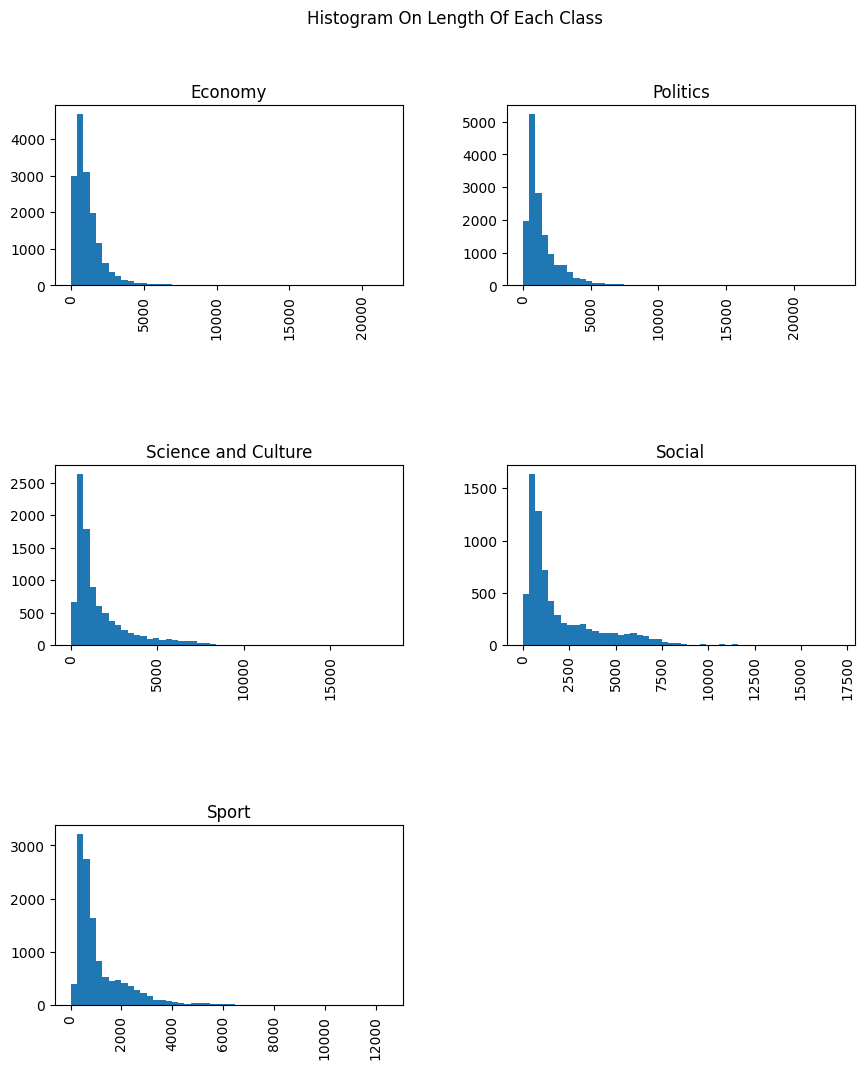

In [109]:
fig, ax = plt.subplots(figsize=(10,12))
df.hist(column='length',by='class',bins=50,ax=ax)
plt.suptitle('Histogram On Length Of Each Class')
plt.subplots_adjust(hspace=1)

plt.show()

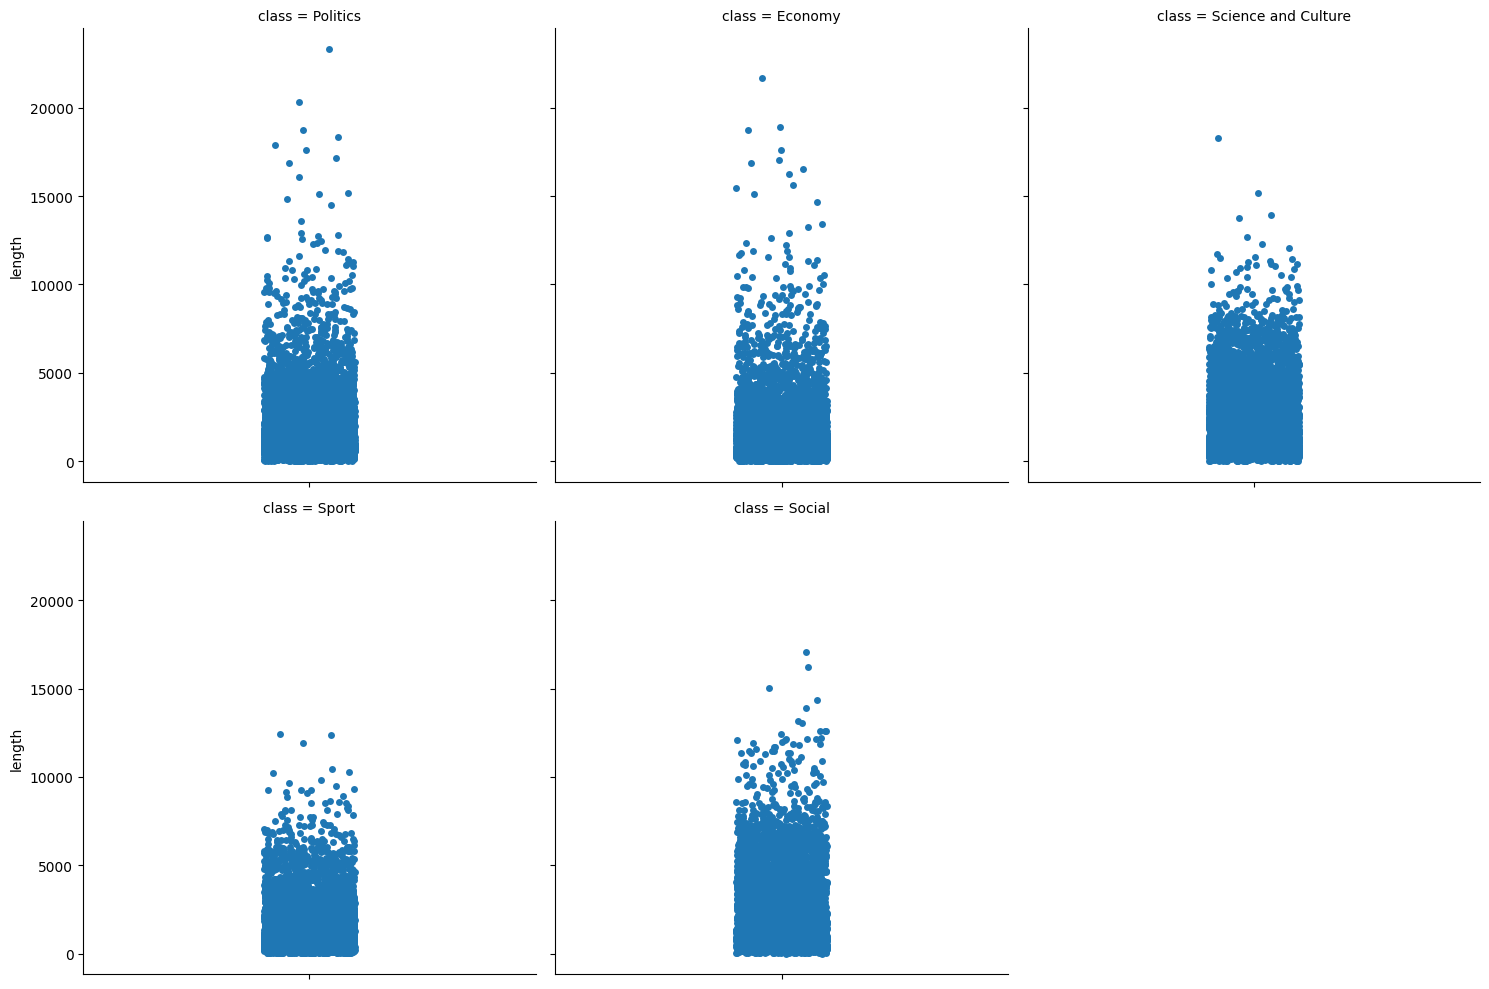

In [127]:
sns.catplot(data=df, y='length', col='class', col_wrap=3, sharex=False)

plt.show()

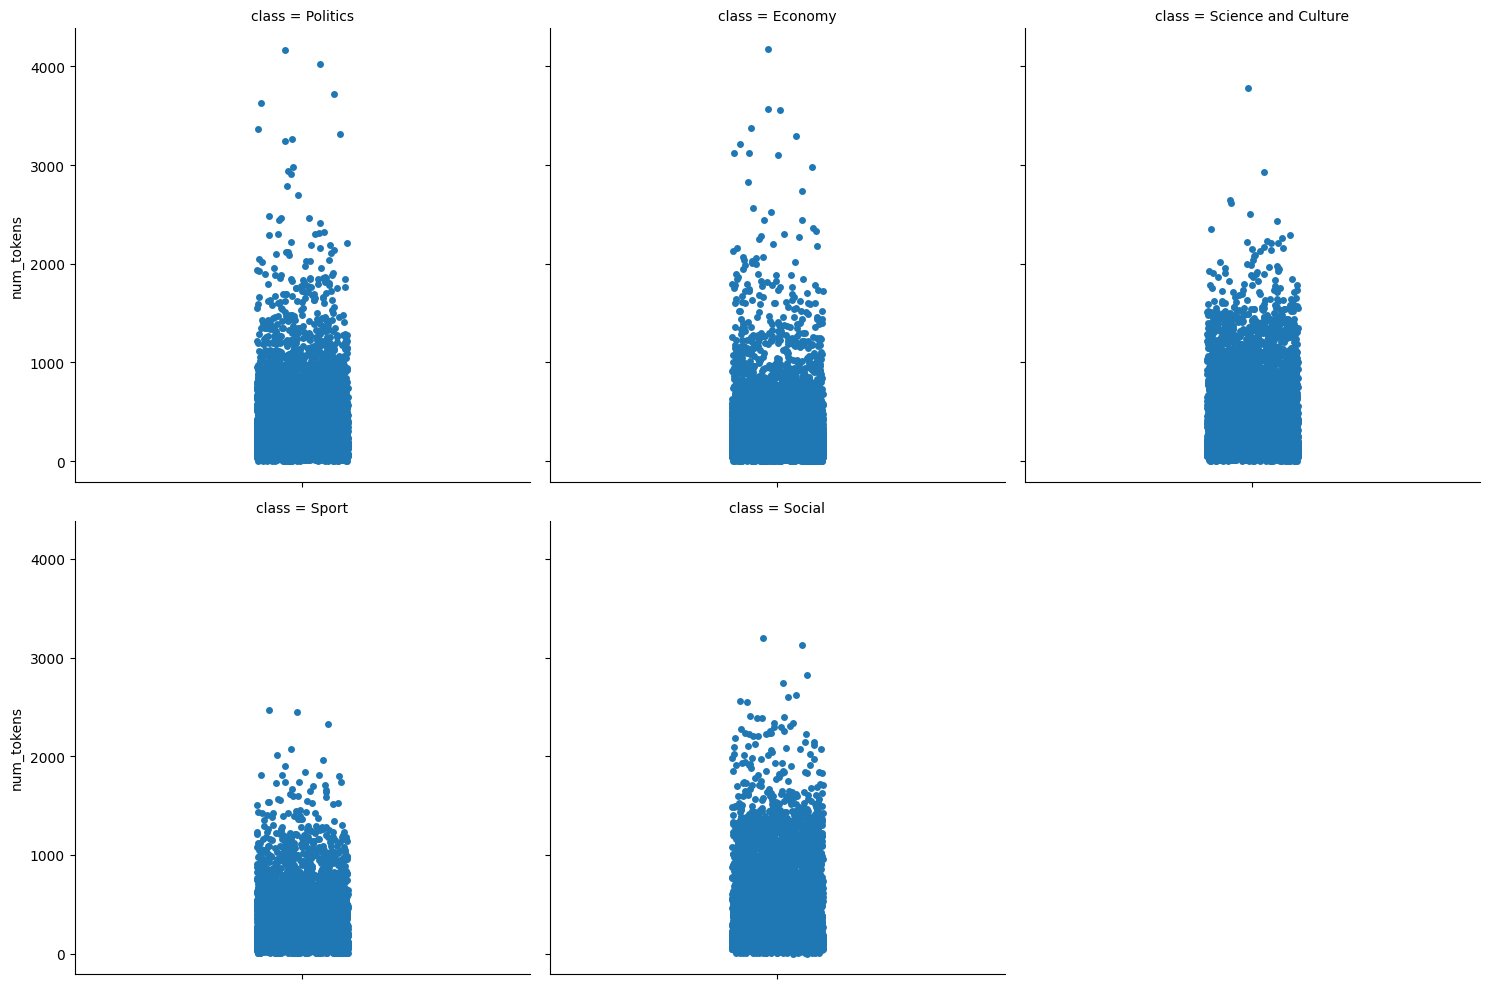

In [128]:
sns.catplot(data=df,y='num_tokens',col='class',col_wrap=3,sharex=False)
plt.show()

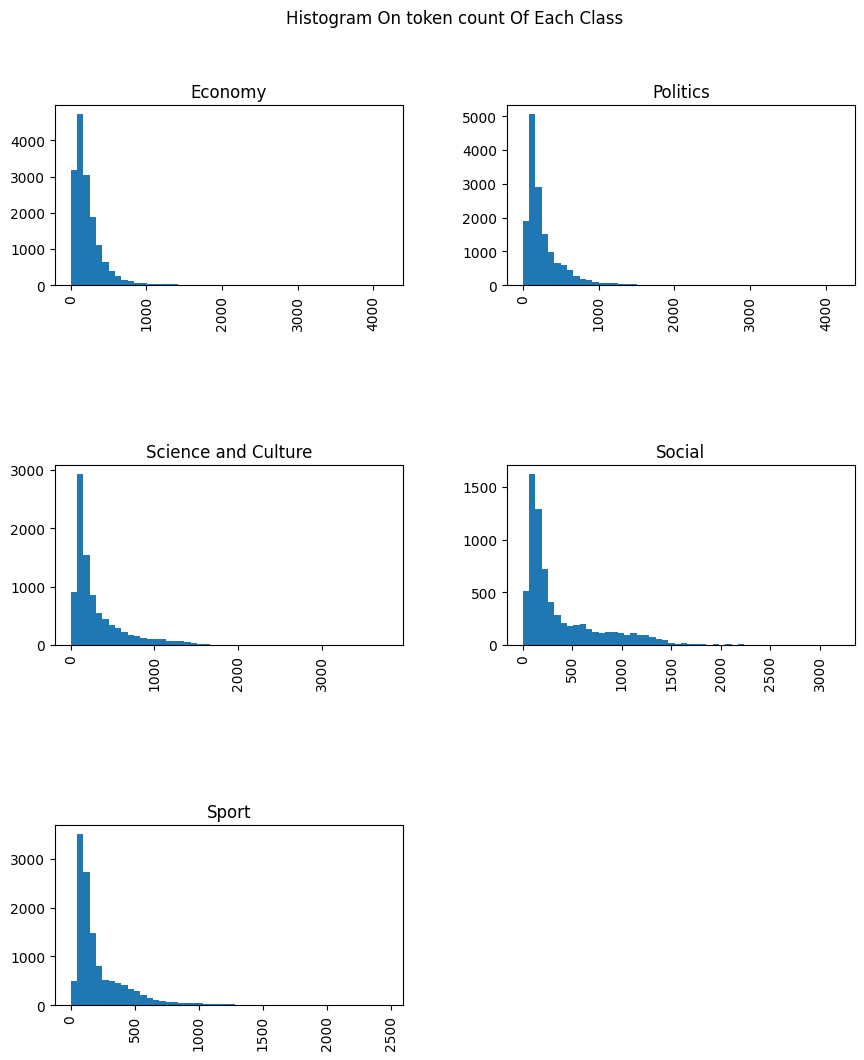

In [115]:
fig, ax = plt.subplots(figsize=(10,12))
df.hist(column='num_tokens',by='class',bins=50,ax=ax)
plt.suptitle('Histogram On token count Of Each Class')
plt.subplots_adjust(hspace=1)
plt.show()

In [132]:
# گروه‌بندی بر اساس ستون دسته بندی
avg_char_count_by_category = df.groupby('class')['length'].mean()
avg_token_count_by_category = df.groupby('class')['num_tokens'].mean()

In [130]:
print(avg_char_count_by_category)

class
Economy                1237.163189
Politics               1478.861150
Science and Culture    1707.393213
Social                 2044.793273
Sport                  1188.432072
Name: length, dtype: float64


In [133]:
print(avg_token_count_by_category)

class
Economy                232.750709
Politics               272.776480
Science and Culture    325.747779
Social                 389.346327
Sport                  225.074314
Name: num_tokens, dtype: float64


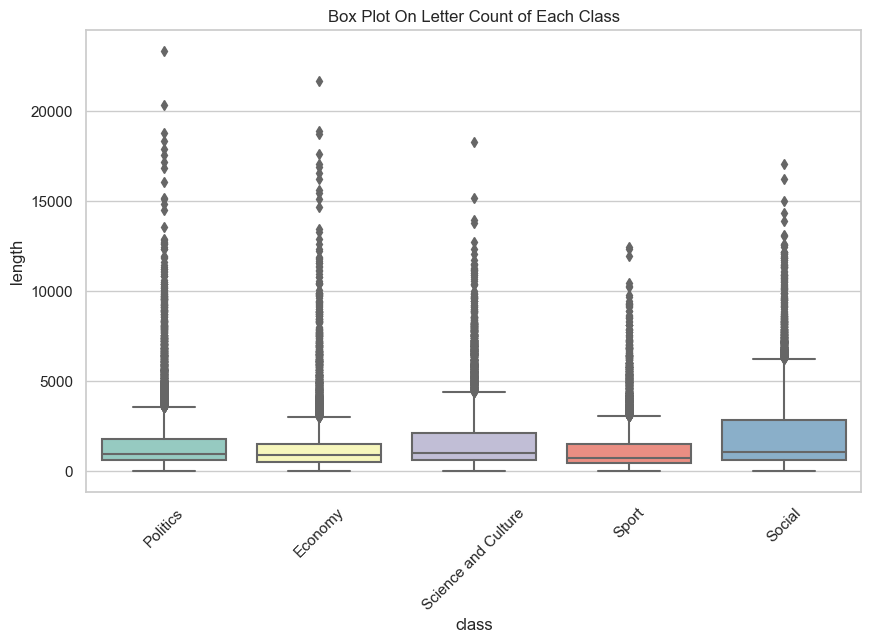

In [137]:
palette = sns.color_palette("Set3")
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='length', data=df, palette=palette)

plt.title('Box Plot On Letter Count of Each Class')
plt.xticks(rotation=45) 
plt.show()

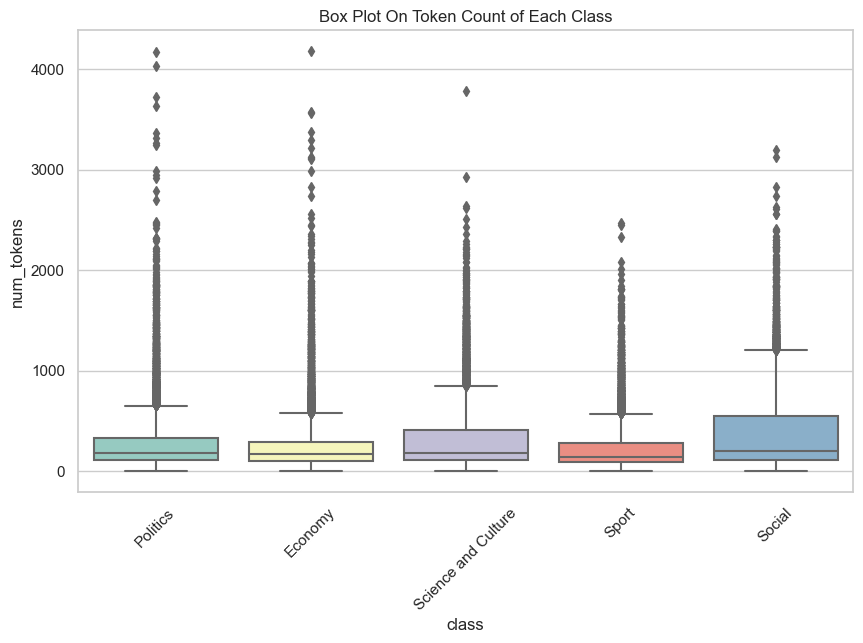

In [139]:
palette = sns.color_palette("Set3")
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='num_tokens', data=df, palette=palette)

plt.title('Box Plot On Token Count of Each Class')
plt.xticks(rotation=45) 
plt.show()

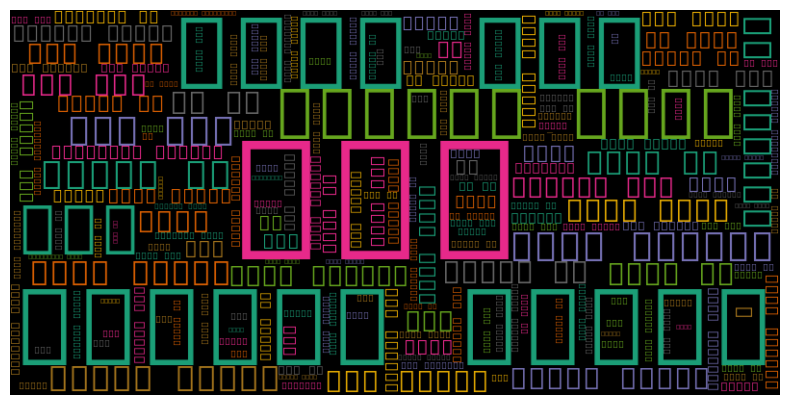

In [142]:
text = ' '.join(df['PP_Text_2'])
wordcloud = WordCloud(width=800, height=400,background_color='black', colormap='Dark2').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
df.dropna(axis=0,inplace=True)

In [5]:
df.shape

(59989, 6)

In [6]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['PP_Text_2'] = df['PP_Text_2'].apply(remove_punctuation)

In [7]:
stopwords = hazm.stopwords_list()
lemma = Lemmatizer()
def remove_hashtags(text):
    tokens = word_tokenize(text)
    processed_tokens = []
    for token in tokens:
        if '#' in token:
            token = token.split('#')[-1]
        processed_tokens.append(token)
    processed_text = ' '.join(processed_tokens)
    return processed_text  
lemmatized_stopwords = [remove_hashtags(lemma.lemmatize(word)) for word in stopwords]


In [8]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in lemmatized_stopwords]
    return ' '.join(filtered_words)

df['PP_Text_2'] = df['PP_Text_2'].apply(remove_stopwords)

In [9]:
df["length"] = df["PP_Text_2"].str.len()
tokenizer = WordTokenizer()
df["num_tokens"] = df["PP_Text_2"].apply(lambda text: len(tokenizer.tokenize(text)))

In [10]:
df.head(7)

,Unnamed: 0,text,class,PP_Text_2,length,num_tokens
0,0,\nاز سوي كميسيون ماده 10 \nاحزابكارگزاران سازن...,Politics,کمیسیون ماده ۱۰ احزابکارگزاران سازندگی مجوز فع...,344,56
1,1,\nخصوصي سازي كارخانه هاي چاي سال آينده \nآغاز ...,Economy,خصوصی کارخانه چای آینده آغاز مدیرعامل سازمان چ...,687,113
2,2,\nتوضيح يك مطلب \nسوم بهمن ماه امسال گزارش طرح...,Science and Culture,توضیح مطلب بهمن ماه امسال گزارش طرح بررسی شناس...,1120,196
3,3,\nبهاي گازوئيل و بنزين در \nفرانسه افزايش يافت...,Economy,بهای گازوئیل بنزین فرانسه افزایش پاریس خبرگزار...,396,70
4,4,\nرئيس سازمان حج و زيارت اعلام كرد \n شهريور 1...,Science and Culture,رئیس سازمان حج زیارت اعلام شهریور ۱۶ زمان ثبت ...,495,95
5,5,\nهمزمان با روز جهاني موزه و هفته ميراث \nجديد...,Science and Culture,همزمان روز جهانی موزه هفته میراث کشور افتتاح ف...,838,150
6,6,\nنگراني درلوشامپيونا \nسهيلا قاسمي \nبازار نق...,Sport,نگران درلوشامپیونا سهیلا قاسم بازار نقل انتقال...,3010,510


In [11]:
text = ' '.join(df['PP_Text_2'].astype(str))

In [12]:
wc = WordCloudFa()
word_cloud = wc.generate(text)

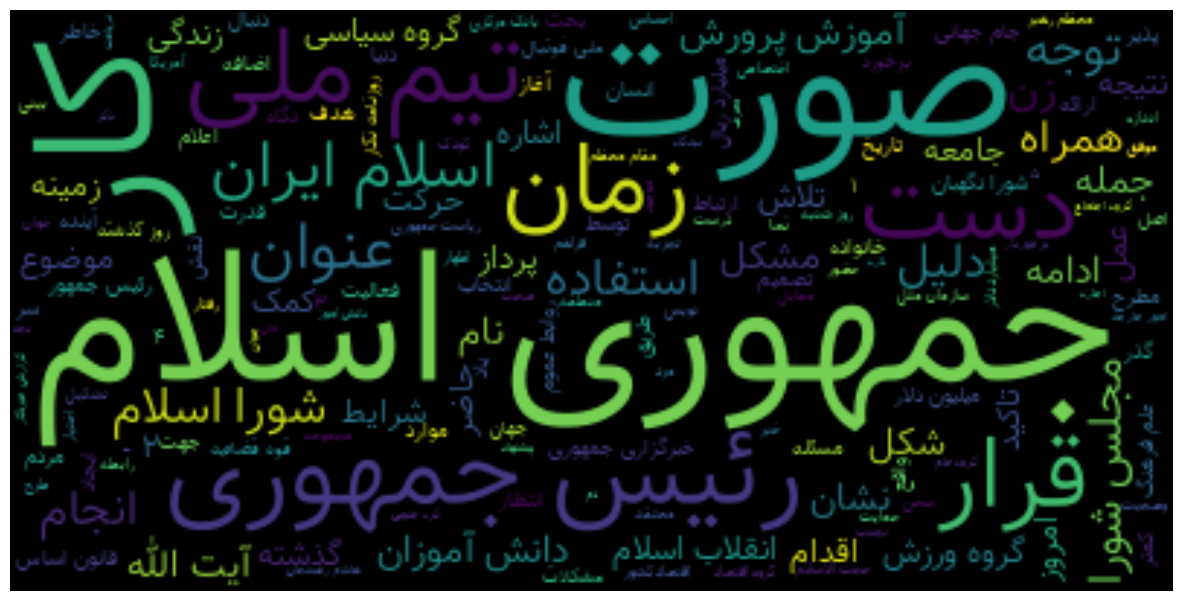

In [13]:
image = word_cloud.to_image()
plt.figure(figsize=(15, 12))
plt.imshow(image, interpolation='bilinear')
plt.axis("off")
plt.show()

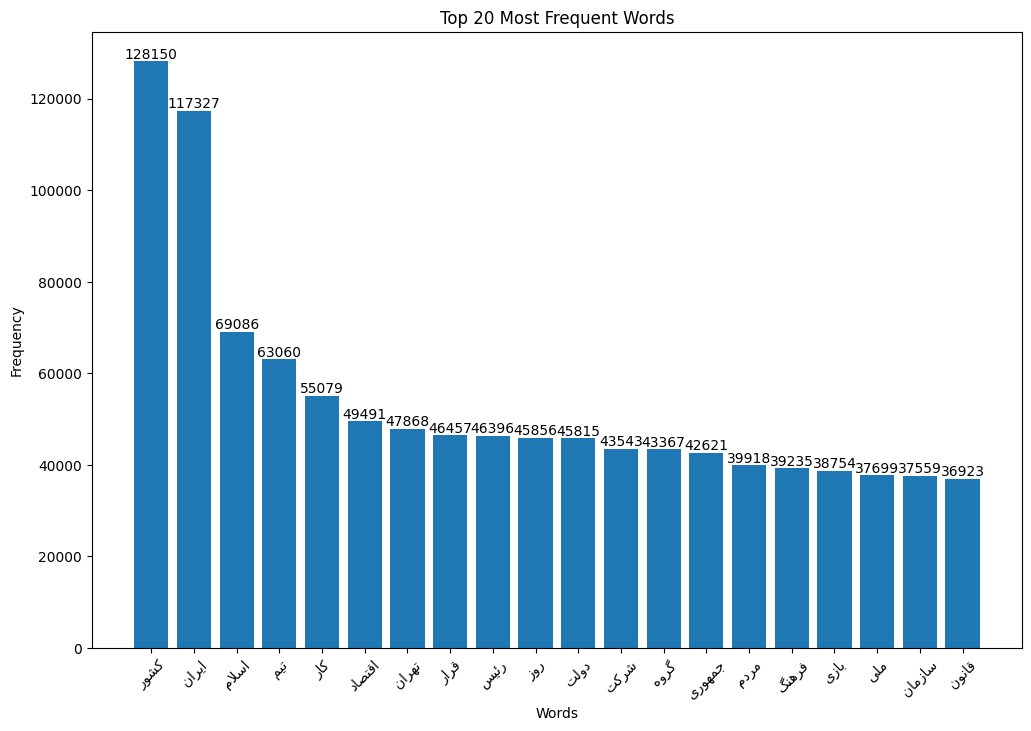

In [39]:
combined_text = ' '.join(df['PP_Text_2'])

tokens = word_tokenize(combined_text)
word_freq = Counter(tokens)
top_words = word_freq.most_common(20)
words, frequencies = zip(*top_words)
persian_words = [get_display(reshape(word)) for word in words]

plt.figure(figsize=(12, 8))
plt.bar(persian_words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)
plt.show()

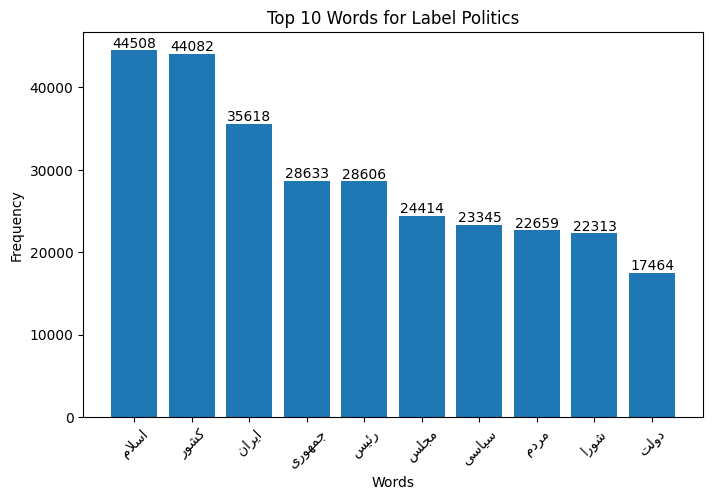

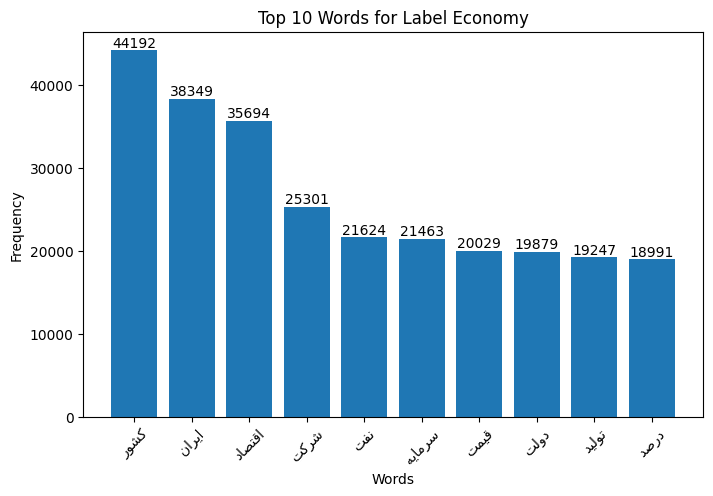

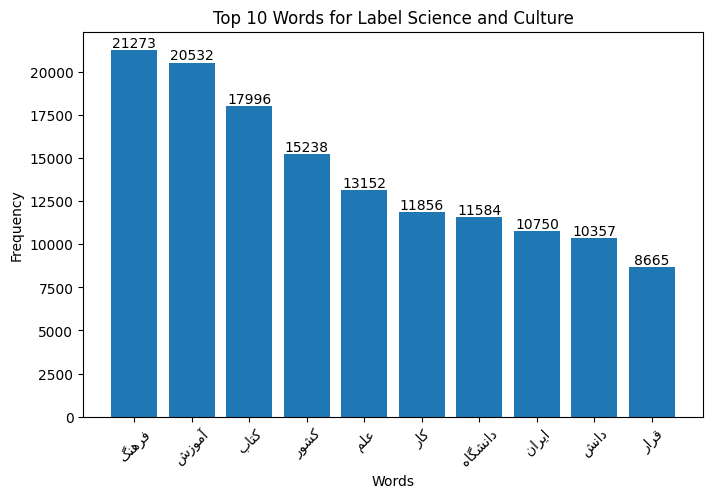

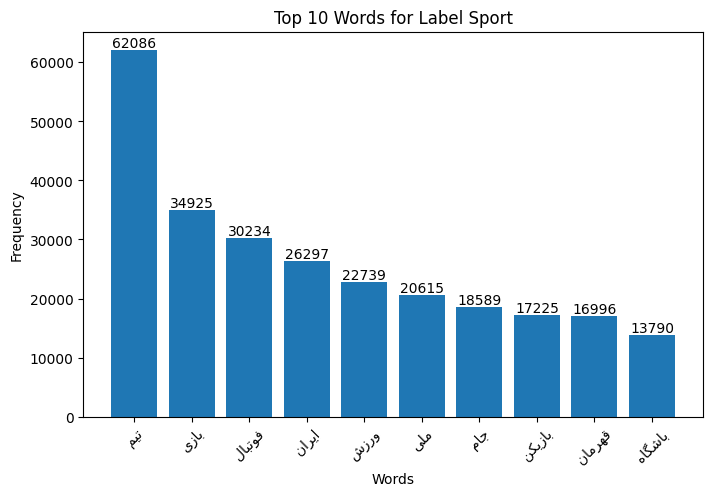

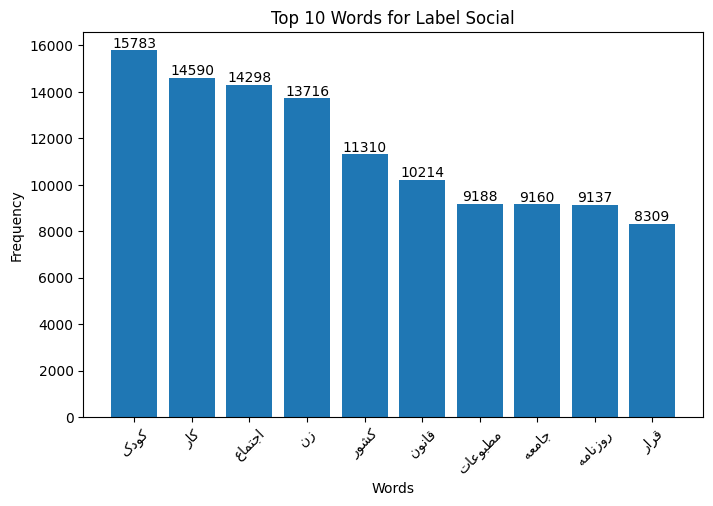

In [30]:
from collections import Counter

word_frequencies = {}

for label in df['class'].unique():
    subset = df[df['class'] == label]
    combined_text = ' '.join(subset['PP_Text_2'])
    tokens = word_tokenize(combined_text)
    word_freq = Counter(tokens)
    top_words = word_freq.most_common(10)
    word_frequencies[label] = top_words

for label, top_words in word_frequencies.items():
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(8, 5))
    persian_words = [get_display(reshape(lab)) for lab in words]
    plt.bar(persian_words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words for Label {label}')
    plt.xticks(rotation=45)

    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)

    plt.show()

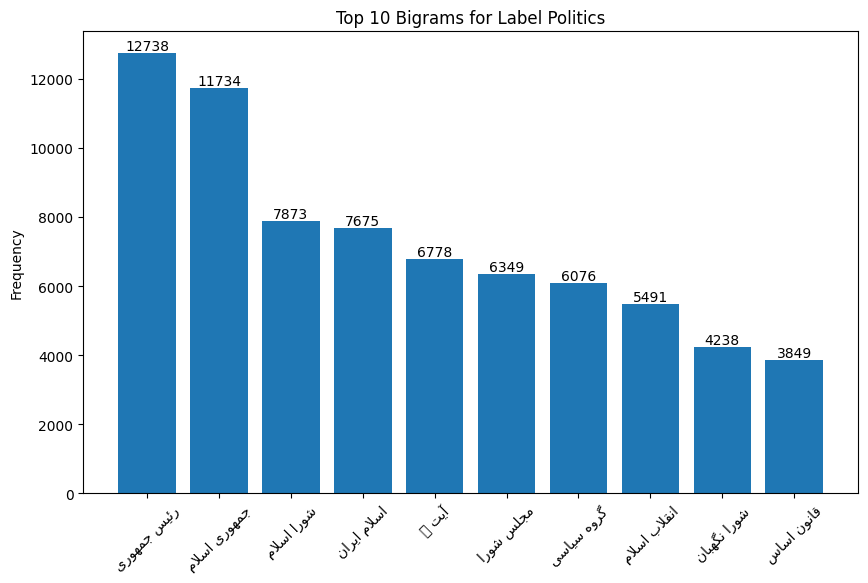

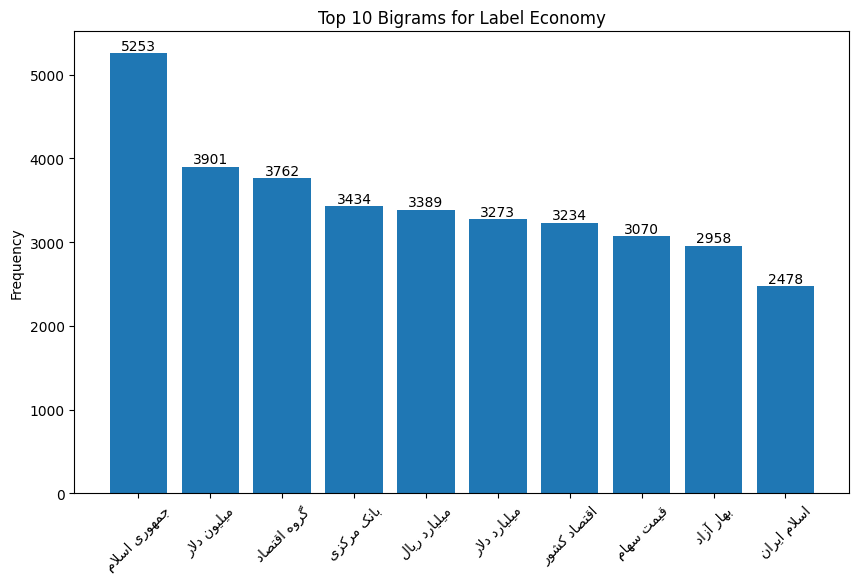

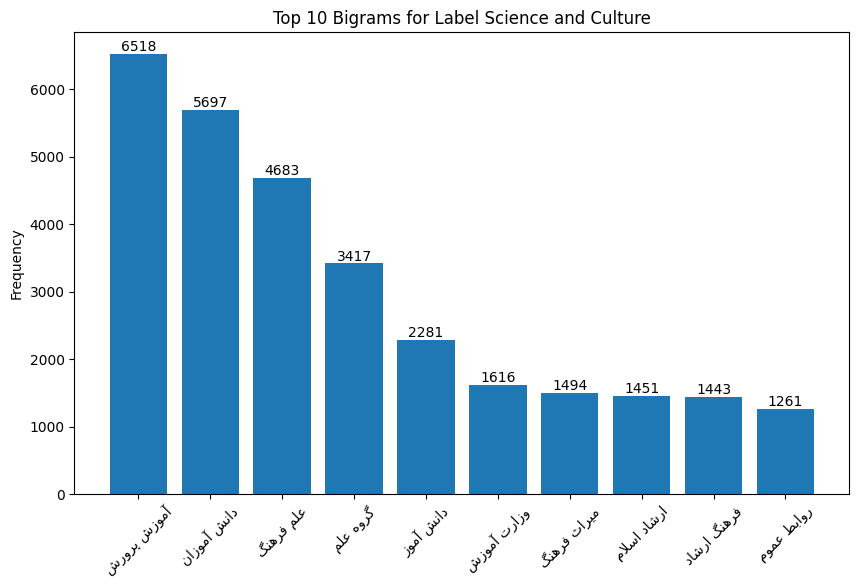

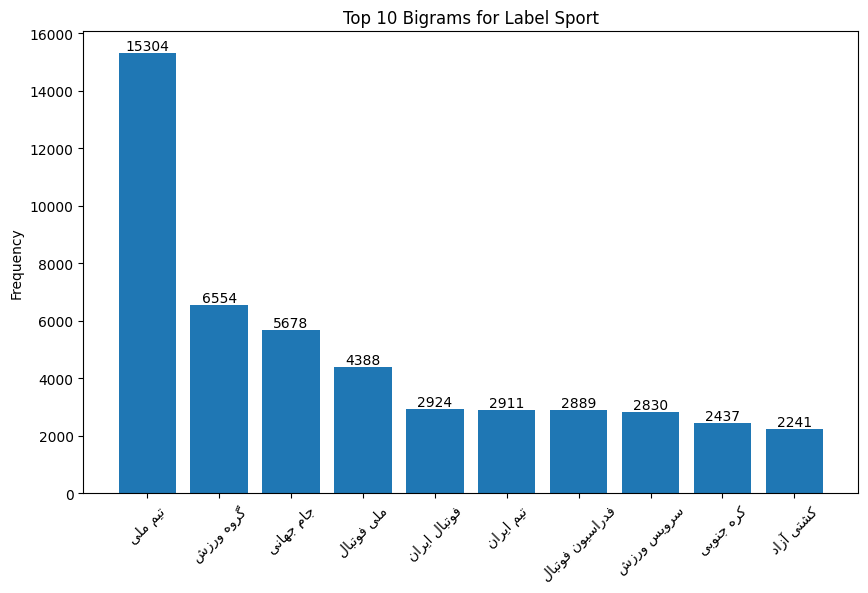

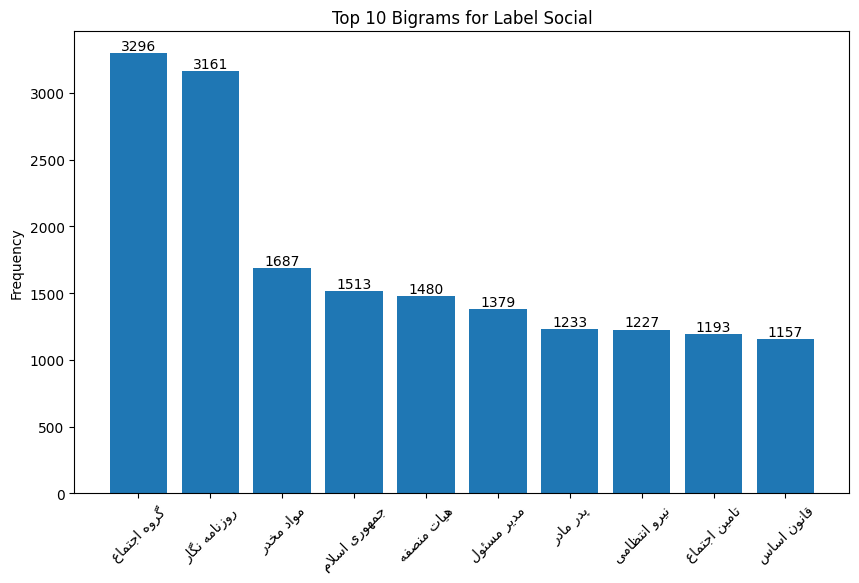

In [41]:
from nltk.util import ngrams
bigram_frequencies = {}

for label in df['class'].unique():
    subset = df[df['class'] == label]
    combined_text = ' '.join(subset['PP_Text_2'])
    tokens = word_tokenize(combined_text)
    bigrams = list(ngrams(tokens, 2))
    bigram_freq = Counter(bigrams)
    top_bigrams = bigram_freq.most_common(10)
    bigram_frequencies[label] = top_bigrams

for label, top_bigrams in bigram_frequencies.items():
    bigrams, frequencies = zip(*top_bigrams)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 6))
    persian_bigrams = [get_display(reshape(bigram)) for bigram in bigram_labels]
    plt.bar(persian_bigrams, frequencies)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Bigrams for Label {label}')
    plt.xticks(rotation=45)
    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)
    plt.show()

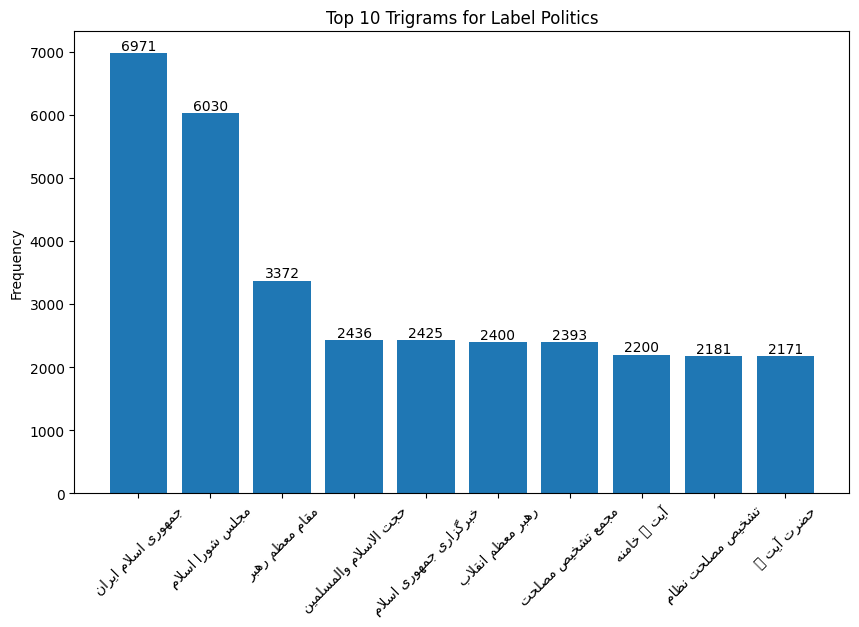

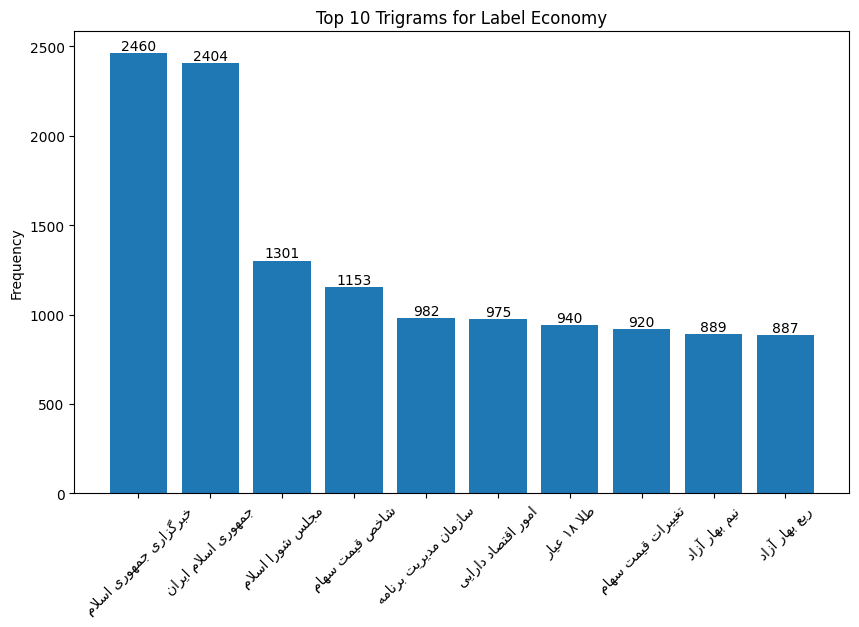

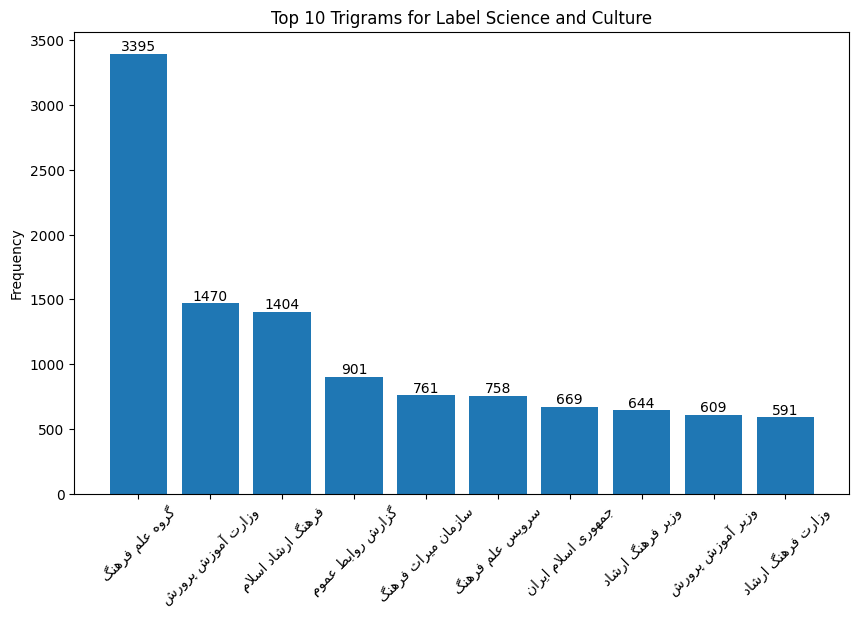

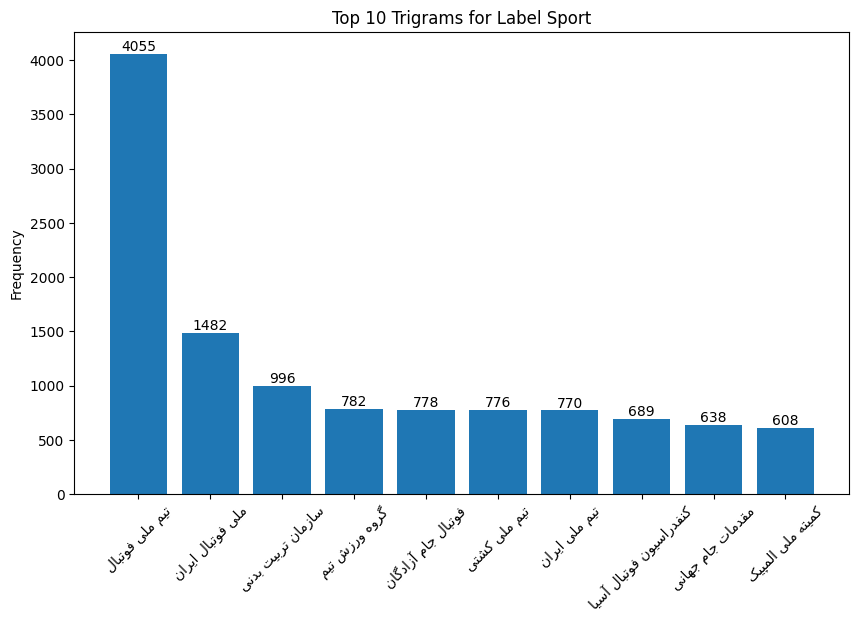

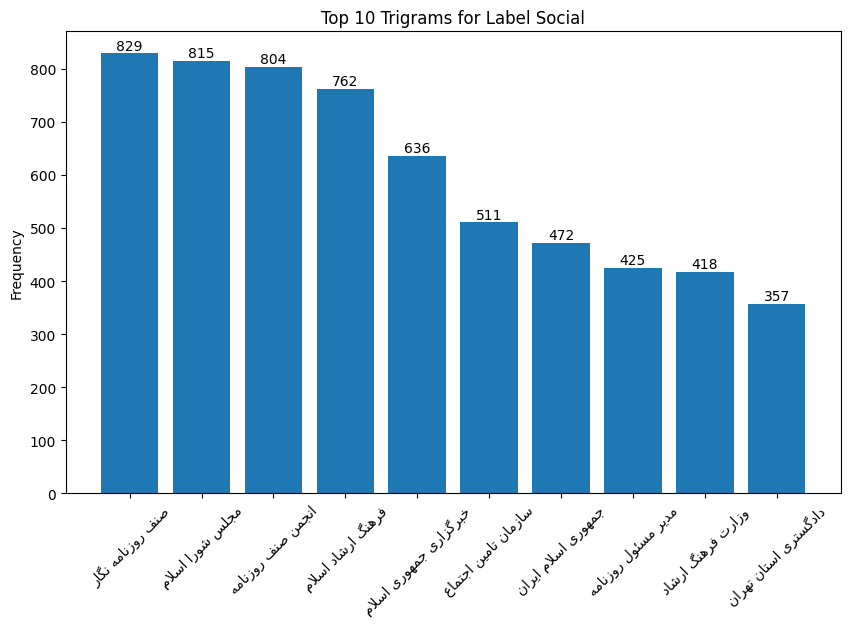

In [40]:
from nltk.util import ngrams
trigram_frequencies = {}

for label in df['class'].unique():
    subset = df[df['class'] == label]
    combined_text = ' '.join(subset['PP_Text_2'])
    tokens = word_tokenize(combined_text)
    trigrams = list(ngrams(tokens, 3))
    trigram_freq = Counter(trigrams)
    top_trigrams = trigram_freq.most_common(10)
    trigram_frequencies[label] = top_trigrams

for label, top_trigrams in trigram_frequencies.items():
    trigrams, frequencies = zip(*top_trigrams)
    trigram_labels = [' '.join(trigram) for trigram in trigrams]
    plt.figure(figsize=(10, 6))
    persian_trigrams = [get_display(reshape(trigram)) for trigram in trigram_labels]
    plt.bar(persian_trigrams, frequencies)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Trigrams for Label {label}')
    plt.xticks(rotation=45)
    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)
    plt.show()

In [43]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [45]:
df.to_csv('final_train.csv',encoding='utf-8-sig',index=False)